# **Model Building**



---
---
## **1. Setting Up**
---
---

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import FunctionTransformer, RobustScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, label_binarize

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import VotingClassifier
from feature_engine.discretisation import EqualFrequencyDiscretiser

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.metrics import roc_curve, auc


import plotly.graph_objects as go
import plotly.express as px

import sys
sys.path.insert(0, '../src')

from sklearn import set_config
set_config(display='diagram')

from sklearn import set_config
set_config(transform_output='pandas')

import joblib


%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../data/aug_train.csv')
train, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Response'])

display(train.head())
train.info()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
97017,142046,Female,23,1,6.0,1,< 1 Year,Yes,40694.0,152.0,148,0
150461,312938,Male,29,1,36.0,1,< 1 Year,No,2630.0,160.0,257,0
277654,470466,Female,24,1,35.0,1,< 1 Year,No,26622.0,152.0,183,0
139225,380625,Female,43,1,8.0,0,1-2 Year,Yes,44543.0,26.0,117,0
374283,448542,Male,25,1,28.0,1,< 1 Year,No,42321.0,152.0,72,0


<class 'pandas.core.frame.DataFrame'>
Index: 305723 entries, 97017 to 244010
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    305723 non-null  int64  
 1   Gender                305723 non-null  object 
 2   Age                   305723 non-null  int64  
 3   Driving_License       305723 non-null  int64  
 4   Region_Code           305723 non-null  float64
 5   Previously_Insured    305723 non-null  int64  
 6   Vehicle_Age           305723 non-null  object 
 7   Vehicle_Damage        305723 non-null  object 
 8   Annual_Premium        305723 non-null  float64
 9   Policy_Sales_Channel  305723 non-null  float64
 10  Vintage               305723 non-null  int64  
 11  Response              305723 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 30.3+ MB


In [3]:
selection = [
    'Age', 
    'Driving_License', 
    'Region_Code',
    'Previously_Insured', 
    'Vehicle_Age', 
    'Vehicle_Damage', 
    'Annual_Premium',
    'Policy_Sales_Channel',
], 

binaries= ['Driving_License', 'Previously_Insured',]
discrete = ['Region_Code', 'Policy_Sales_Channel', 'Vehicle_Age']


---
---
## **2. Preprocessing**
---
---
### **Cleaning Actions Required**

#### **Drop**
- id

#### **Binarize**
- Gender
- Vehicle_Damage

#### **Discretize**
- Vehicle_Age

#### **Impute**
- All variables, in prediction of new data handling


### **Feature Engineering Actions Required**    


#### **Scale**
- Age: Standardization
  - We should expect it to be normally distributed, with a cutoff at the driving license age eligibility (18 years old)
- Annual_Premium: RobustScaling
  - A  fat right-tail towards the right may cause problems, i'll opt for a drastic normalizer instead of outlier trimming

#### **Drop**
- VarianceThreshold set to 10% will get rid of the Vintage column 

---


---
### **Building the Data Cleaning Pipeline**


In [4]:

gender_pipeline = make_pipeline(
    OrdinalEncoder(categories=[['Male', 'Female']]),
)
    
vehicle_damage_pipeline = make_pipeline(
    OrdinalEncoder(categories=[['No', 'Yes']]),
)

vehicle_age_pipeline = make_pipeline(
    OrdinalEncoder(categories=[sorted(train['Vehicle_Age'].unique())]),

)

region_code_pipeline = make_pipeline(
    EqualFrequencyDiscretiser(q=4)
)

policy_sales_channel_pipeline = make_pipeline(
    EqualFrequencyDiscretiser(q=4)
)

continuous_pipeline = make_pipeline(
    RobustScaler(),
)

age_pipeline = make_pipeline(
    StandardScaler(),
)

iterative_imputer = IterativeImputer()

column_transformer = make_column_transformer(
    (gender_pipeline, ['Gender']),
    (vehicle_damage_pipeline, ['Vehicle_Damage']),
    (vehicle_age_pipeline, ['Vehicle_Age']),
    (region_code_pipeline, ['Region_Code']),
    (policy_sales_channel_pipeline, ['Policy_Sales_Channel']),
    (continuous_pipeline, ['Annual_Premium']),
    (age_pipeline, ['Age']),
    ('passthrough', ['Driving_License', 'Previously_Insured',]),
)

feature_engineering_pipeline = make_pipeline(
    column_transformer,
    iterative_imputer,
    VarianceThreshold(threshold=0.1)
)
feature_engineering_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Male',
                                                                                               'Female']]))]),
                                                  ['Gender']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['No',
                                                                                               'Yes']]))]),
                                                  ['Vehicle_Damage']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEnc...
                                                  ['Policy_Sales_Channel']),
                                                 ('pipeline-6',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Annual_Premium']),
                                                 ('pipeline-7',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('passthrough', 'passthrough',
                                                  ['Driving_License',
                                                   'Previously_Insured'])])),
                ('iterativeimputer', IterativeImputer()),
                ('variancethreshold', VarianceThreshold(threshold=0.1))])

---
---
## **3. Grid Search**
---
---

### **Models**

#### **Linear**
- Logistic Regression
- Stochastic Gradient Descent Classifier

#### **Neighbors**
- K Nearest Neighbors Classifier

#### **Tree**
- Random Forest Classifier
- Gradient Boosting Classifier

In [5]:

knn_param_grid = {
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2],
}

svc_param_grid = {
    'classifier': [SVC()],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': [0.1, 1, 10, 100],
}


lr_param_grid = {
    'classifier': [LogisticRegression()],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
}

# Define the parameter grid for Random Forest
rf_param_grid4 = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [100, 200, 400],
    'classifier__max_depth': [3, 5, 7],
    'classifier__bootstrap': [True, False],
}

# Define the parameter grid for Gradient Boosting
gbc_param_grid = {
    'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 1],
}


sgdc_param_grid = {
    'classifier': [SGDClassifier()],
    'classifier__loss': ['log', 'modified_huber'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__max_iter': [1000],
    'classifier__learning_rate': ['optimal', 'invscaling', 'adaptive'],
}


sgd_param_grid2 = {
    'classifier': [SGDClassifier()],
    'classifier__loss': ['modified_huber', 'log'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__max_iter': [1000],
    'classifier__learning_rate': ['constant'],
    'classifier__eta0': [0.01, 0.1, 1, 10, 100]
}


param_grid = [sgdc_param_grid, knn_param_grid, gbc_param_grid, lr_param_grid, rf_param_grid4, sgd_param_grid2]

clf_pipeline = Pipeline(steps=[
    ('preprocessor', feature_engineering_pipeline),
    ('classifier', None) 
])


grid_search = GridSearchCV(clf_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(train.drop(columns='Response'), train['Response'])

print(grid_search.best_params_)

results = pd.DataFrame(grid_search.cv_results_)
results['classifier_name'] = results['param_classifier'].apply(lambda x: x.__class__.__name__)
results = results.sort_values(by='mean_test_score', ascending=False)

results.to_csv('../data/grid_search_results.csv', index=False)
joblib.dump(grid_search, '../models/grid_search.pkl')

results.head(5)


Fitting 5 folds for each of 169 candidates, totalling 845 fits


[CV] END classifier=SGDClassifier(), classifier__alpha=0.0001, classifier__learning_rate=optimal, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2; total time=   2.5s
[CV] END classifier=SGDClassifier(), classifier__alpha=0.0001, classifier__learning_rate=optimal, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2; total time=   3.0s
[CV] END classifier=SGDClassifier(), classifier__alpha=0.0001, classifier__learning_rate=optimal, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2; total time=   3.0s
[CV] END classifier=SGDClassifier(), classifier__alpha=0.0001, classifier__learning_rate=optimal, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=elasticnet; total time=   3.3s
[CV] END classifier=SGDClassifier(), classifier__alpha=0.0001, classifier__learning_rate=optimal, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2; total time=   3.7s
[CV] END classifier=SGDClassifier(), class

/home/mln/miniconda3/envs/docker_ready/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 845.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mln/miniconda3/envs/docker_ready/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mln/miniconda3/envs/docker_ready/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mln/miniconda3/envs/docker_r

{'classifier': SGDClassifier(), 'classifier__alpha': 0.001, 'classifier__eta0': 0.1, 'classifier__learning_rate': 'constant', 'classifier__loss': 'modified_huber', 'classifier__max_iter': 1000, 'classifier__penalty': 'elasticnet'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__alpha,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,...,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,classifier_name
117,1.984215,0.200251,0.146812,0.020892,SGDClassifier(),0.001,constant,modified_huber,1000,elasticnet,...,"{'classifier': SGDClassifier(), 'classifier__a...",0.521947,0.510678,0.522150,0.539295,0.519346,0.522683,0.009296,1,SGDClassifier
123,2.478127,0.293747,0.153881,0.039037,SGDClassifier(),0.001,constant,modified_huber,1000,elasticnet,...,"{'classifier': SGDClassifier(), 'classifier__a...",0.481659,0.402677,0.515349,0.532198,0.494268,0.485230,0.044772,2,SGDClassifier
58,1.960697,0.171683,13.389515,0.423818,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,...,"{'classifier': KNeighborsClassifier(), 'classi...",0.427663,0.424788,0.435200,0.431488,0.435246,0.430877,0.004136,3,KNeighborsClassifier
62,2.552820,0.180834,14.235396,0.503477,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,...,"{'classifier': KNeighborsClassifier(), 'classi...",0.429087,0.426157,0.432148,0.433527,0.433366,0.430857,0.002839,4,KNeighborsClassifier
60,1.372704,0.026317,11.735331,1.271114,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,...,"{'classifier': KNeighborsClassifier(), 'classi...",0.428253,0.423306,0.434096,0.430661,0.435335,0.430330,0.004313,5,KNeighborsClassifier


In [6]:
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__alpha,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,...,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,classifier_name
117,1.984215,0.200251,0.146812,0.020892,SGDClassifier(),0.001,constant,modified_huber,1000,elasticnet,...,"{'classifier': SGDClassifier(), 'classifier__a...",0.521947,0.510678,0.522150,0.539295,0.519346,0.522683,0.009296,1,SGDClassifier
123,2.478127,0.293747,0.153881,0.039037,SGDClassifier(),0.001,constant,modified_huber,1000,elasticnet,...,"{'classifier': SGDClassifier(), 'classifier__a...",0.481659,0.402677,0.515349,0.532198,0.494268,0.485230,0.044772,2,SGDClassifier
58,1.960697,0.171683,13.389515,0.423818,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,...,"{'classifier': KNeighborsClassifier(), 'classi...",0.427663,0.424788,0.435200,0.431488,0.435246,0.430877,0.004136,3,KNeighborsClassifier
62,2.552820,0.180834,14.235396,0.503477,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,...,"{'classifier': KNeighborsClassifier(), 'classi...",0.429087,0.426157,0.432148,0.433527,0.433366,0.430857,0.002839,4,KNeighborsClassifier
60,1.372704,0.026317,11.735331,1.271114,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,...,"{'classifier': KNeighborsClassifier(), 'classi...",0.428253,0.423306,0.434096,0.430661,0.435335,0.430330,0.004313,5,KNeighborsClassifier


<Axes: xlabel='classifier_name'>

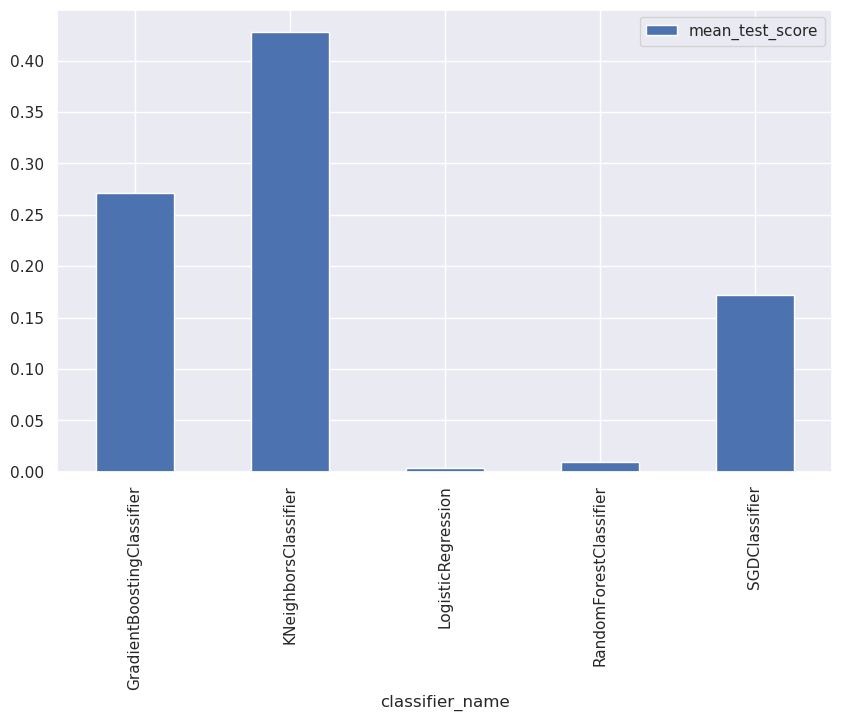

In [7]:
# Create a new column 'classifier_name' that contains the name of the classifier
results.to_csv('../data/grid_search_results.csv', index=False)

# Group by the 'classifier_name' column and calculate the mean of 'mean_test_score'
gb = results.groupby('classifier_name')['mean_test_score'].mean()

# Convert the groupby object to a DataFrame and reset the index
gb_df = gb.reset_index()

# Plot the data
gb_df.plot(x='classifier_name', y='mean_test_score', kind='bar', figsize=(10, 6))

---
---
## **4. Tri-Model Voting Classifier**
---
---

In [8]:


best_knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', p=2)
best_gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1)
best_sgd = SGDClassifier(alpha=0.001, learning_rate='optimal', loss='modified_huber', max_iter=1000, penalty='elasticnet') #squared_hinge


clf_pipeline = Pipeline(steps=[
    ('preprocessor', feature_engineering_pipeline),
    ('classifier', LogisticRegression(solver='liblinear'))
])


voting_clf_hard = VotingClassifier(
    estimators=[('GBC', best_gb), ('KNN', best_knn), ('SGD', best_sgd)],
    voting='hard',
    n_jobs=-1,
    verbose=3
    
    
    # Use soft voting, which uses predicted probabilities for voting
)


voting_clf = VotingClassifier(
    estimators=[('GBC', best_gb), ('KNN', best_knn), ('SGD', best_sgd)],
    voting='soft',
    n_jobs=-1,
    verbose=3
    
    
    # Use soft voting, which uses predicted probabilities for voting
)
vc_clf_pipeline = Pipeline(steps=[
    ('preprocessor', feature_engineering_pipeline),
    ('classifier', voting_clf)
])

vc_clf_pipeline.fit(train.drop(columns='Response'), train['Response'])


[Voting] ...................... (2 of 3) Processing KNN, total=   0.3s
[Voting] ...................... (3 of 3) Processing SGD, total=   0.5s
[Voting] ...................... (1 of 3) Processing GBC, total=  38.4s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Male',
                                                                                                                'Female']]))]),
                                                                   ['Gender']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['No',
                                                                                                                'Yes']]))]),
                                                                   ['Vehicle_Damage']),
                                                                  ('pipeline-3',
                                                                   Pipeline(ste...
                                 ('iterativeimputer', IterativeImputer()),
                                 ('variancethreshold',
                                  VarianceThreshold(threshold=0.1))])),
                ('classifier',
                 VotingClassifier(estimators=[('GBC',
                                               GradientBoostingClassifier(n_estimators=300)),
                                              ('KNN',
                                               KNeighborsClassifier(n_neighbors=7)),
                                              ('SGD',
                                               SGDClassifier(alpha=0.001,
                                                             loss='modified_huber',
                                                             penalty='elasticnet'))],
                                  n_jobs=-1, verbose=3, voting='soft'))])

In [9]:
from utils import is_fitted

from sklearn.utils.validation import check_is_fitted

def is_fitted(estimator):
    try:
        check_is_fitted(estimator)
        return True
    except NotFittedError:
        return False
is_fitted(vc_clf_pipeline)

True

In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.metrics import classification_report_imbalanced


y_pred = vc_clf_pipeline.predict(valid.drop(columns='Response'))
print(classification_report_imbalanced(valid['Response'], y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.96      0.21      0.91      0.45      0.22     63911
          1       0.53      0.21      0.96      0.30      0.45      0.19     12520

avg / total       0.81      0.84      0.33      0.81      0.45      0.21     76431



In [11]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go
import plotly.express as px
import viz


y_pred_proba_class_1 = vc_clf_pipeline.predict_proba(valid.drop(columns='Response'))[:, 1]
viz.plot_roc_curve(valid['Response'], y_pred_proba_class_1, title='Voting Classifier')

In [12]:
from sklearn.metrics import classification_report

y_pred = vc_clf_pipeline.predict(valid.drop(columns='Response'))

print(classification_report(valid['Response'], y_pred))
# print with predict_proba  
#threshold at 0.33

y_pred_proba = vc_clf_pipeline.predict_proba(valid.drop(columns='Response'))
ypred = (y_pred_proba[:,1] >= 0.33).astype('int')
print(classification_report(valid['Response'], ypred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     63911
           1       0.53      0.21      0.30     12520

    accuracy                           0.84     76431
   macro avg       0.69      0.59      0.60     76431
weighted avg       0.81      0.84      0.81     76431

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     63911
           1       0.47      0.75      0.58     12520

    accuracy                           0.82     76431
   macro avg       0.71      0.79      0.73     76431
weighted avg       0.87      0.82      0.84     76431



In [14]:
y_pred_proba = grid_search.best_estimator_.predict_proba(valid)



In [15]:
tt = y_pred_proba[:, 1] > 0.4
print(classification_report_imbalanced(valid['Response'], tt))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.65      0.99      0.78      0.80      0.61     63911
          1       0.35      0.99      0.65      0.52      0.80      0.66     12520

avg / total       0.89      0.70      0.93      0.74      0.80      0.62     76431

